In [1]:
!pip install swifter

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure, plot
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import swifter
from geopy.distance import geodesic as GD

pd.set_option('display.max_columns', 200)


In [3]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [276]:
def plot_feature_importance(importance, names, message="", save_img=False):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[:20]
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title('FEATURE IMPORTANCE' + " " + message)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    if save_img and message:
        plt.savefig(f'./svo_hack_images/{message}.png', bbox_inches='tight')
    elif save_img:
        plt.savefig('./svo_hack_images/general.png', bbox_inches='tight')
    else:
        pass

In [245]:
def calc_distance(lat, lon):
    SVO_airport = (55.972641, 37.414581)
    dest_airport = (lat, lon) 
    return GD(SVO_airport, dest_airport).km

In [246]:
def prepare_revenue(revenue):
    revenue = revenue.rename(columns={"Дата": "date", 
                                            "Дата с разбивкой по 30 минут": "timeThirty",
                                            "Прибыль на момент времени": "revenue",
                                            "Точка продаж": "point",
                                           })

    revenue['revenue'] = revenue['revenue'].apply(lambda x: str(x).replace(u'\xa0', u''))
    revenue['revenue'] = revenue['revenue'].apply(lambda x: str(x).replace(u',', u'.'))
    revenue["revenue"] = revenue["revenue"].astype(float)
    return revenue


def prepare_revenue_05(revenue):
    revenue["timeThirty"] = pd.to_datetime(revenue["timeThirty"], utc = True)
    revenue["day_of_week"] = revenue["timeThirty"].dt.dayofweek
    revenue["day_of_year"] = revenue["timeThirty"].dt.dayofyear
    revenue["day"] = revenue["timeThirty"].dt.day
    revenue["month"] = revenue["timeThirty"].dt.month
    revenue["hour"] = revenue["timeThirty"].dt.hour
    revenue["minutes"] = revenue["timeThirty"].dt.minute
    revenue = revenue.merge(mean_revenue, how='left', left_on='point', right_on='point')

    revenue["is_weekend"] = np.logical_or(False, revenue["day_of_week"] == 6)
    revenue["is_weekend"] = np.logical_or(revenue["is_weekend"], revenue["day_of_week"] == 7)
    revenue["is_weekend"] = np.logical_or(revenue["is_weekend"], revenue["day"] == 2)
    revenue["is_weekend"] = np.logical_or(revenue["is_weekend"], revenue["day"] == 3)
    revenue["is_weekend"] = np.logical_or(revenue["is_weekend"], revenue["day"] == 9)
    revenue["is_weekend"] = np.logical_or(revenue["is_weekend"], revenue["day"] == 10)
    revenue["is_weekend"] = revenue["is_weekend"].astype(int)
    
    return revenue


def prepare_revenue_06(revenue):
    revenue["timeThirty"] = pd.to_datetime(revenue["timeThirty"], utc = True)
    revenue["day_of_week"] = revenue["timeThirty"].dt.dayofweek
    revenue["day_of_year"] = revenue["timeThirty"].dt.dayofyear
    revenue["day"] = revenue["timeThirty"].dt.day
    revenue["month"] = revenue["timeThirty"].dt.month
    revenue["hour"] = revenue["timeThirty"].dt.hour
    revenue["minutes"] = revenue["timeThirty"].dt.minute
    revenue = revenue.merge(mean_revenue, how='left', left_on='point', right_on='point')

    revenue["is_weekend"] = np.logical_or(False, revenue["day_of_week"] == 6)
    revenue["is_weekend"] = np.logical_or(revenue["is_weekend"], revenue["day_of_week"] == 7)
    revenue["is_weekend"] = np.logical_or(revenue["is_weekend"], revenue["day"] == 13)
    revenue["is_weekend"] = revenue["is_weekend"].astype(int)
    
    return revenue


### Get revenue

In [247]:
revenue_05 = pd.read_excel("./svo_hack_data/05.2022_Выручка.xlsx")
revenue_06 = pd.read_excel("./svo_hack_data/06.2022_Выручка.xlsx")

revenue_05 = prepare_revenue(revenue_05)
revenue_06 = prepare_revenue(revenue_06)
mean_revenue = revenue_05[["point", "revenue"]].groupby(["point"]).mean().sort_values(by="revenue").reset_index().rename(columns={"revenue": "mean_revenue"})

revenue_05 = prepare_revenue_05(revenue_05)
revenue_06 = prepare_revenue_05(revenue_06)


In [248]:
revenue_05

,date,timeThirty,revenue,point,day_of_week,day_of_year,day,month,hour,minutes,mean_revenue,is_weekend
0,2022-04-30,2022-04-30 23:30:00+00:00,352.5,Точка продаж 23,5,120,30,4,23,30,5485.718908,0
1,2022-05-01,2022-05-01 00:00:00+00:00,981.0,Точка продаж 12,6,121,1,5,0,0,3826.886135,1
2,2022-05-01,2022-05-01 00:00:00+00:00,1574.5,Точка продаж 3,6,121,1,5,0,0,4230.531963,1
3,2022-05-01,2022-05-01 00:00:00+00:00,1963.5,Точка продаж 28,6,121,1,5,0,0,5976.448442,1
4,2022-05-01,2022-05-01 00:00:00+00:00,1649.5,Точка продаж 22,6,121,1,5,0,0,2143.475573,1
...,...,...,...,...,...,...,...,...,...,...,...,...
27351,2022-06-01,2022-06-01 00:00:00+00:00,1155.0,Точка продаж 11,2,152,1,6,0,0,1291.907238,0
27352,2022-06-01,2022-06-01 00:00:00+00:00,532.0,Точка продаж 10,2,152,1,6,0,0,4436.209654,0
27353,2022-06-01,2022-06-01 00:00:00+00:00,453.0,Точка продаж 12,2,152,1,6,0,0,3826.886135,0
27354,2022-06-01,2022-06-01 00:00:00+00:00,1215.0,Точка продаж 16,2,152,1,6,0,0,16566.777030,0


### Get aircraft seats

In [249]:
aircraft_seats = pd.read_csv("./svo_hack_data/aircraft_seats.csv")
aircraft_seats

,aircraft_type,name,seats,seats_C,seats_W,seats_Y
0,320,Airbus A320,140,20,0,120
1,321,Airbus A321,170,28,0,142
2,SU9,Sukhoi Superjet 100-95,87,12,0,75
3,73H,Boeing 737-800 Winglets,158,20,0,138
4,77W,Boeing 777-300ER,402,30,48,324
5,333,Airbus A330-300,296,28,0,268
6,738,Boeing 737-800,158,20,0,138
7,359,Airbus A350-900,316,28,24,264
8,773,Boeing 777-300,427,28,24,375
9,СУ9,Sukhoi Superjet 100-95,87,12,0,75


### Get airports

In [250]:
airports = requests.get("https://www.flightradar24.com/_json/airports.php", headers= {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36 OPR/51.0.2830.55"
    }).json()["rows"]
airports = pd.DataFrame(airports)
airports

,name,iata,icao,lat,lon,country,alt
0,\tMasai Mara Keekorok Airport,KEU,HKKE,-1.586377,35.257462,Kenya,5532
1,A Coruna Airport,LCG,LECO,43.302059,-8.377250,Spain,326
2,Aachen Merzbruck Airport,AAH,EDKA,50.823051,6.186111,Germany,623
3,Aalborg Airport,AAL,EKYT,57.092781,9.849164,Denmark,10
4,Aarhus Airport,AAR,EKAH,56.300011,10.619000,Denmark,82
...,...,...,...,...,...,...,...
4961,Zunyi Xinzhou Airport,ZYI,ZUZY,27.811167,107.245972,China,2723
4962,Zurich Airport,ZRH,LSZH,47.464722,8.549167,Switzerland,1416
4963,Zwara Airport,WAX,HLZW,32.933334,12.083333,Libya,9
4964,Zweibrucken Airport,ZQW,EDRZ,49.209518,7.400647,Germany,1133


### Get weather

In [251]:
weather = pd.read_csv("./svo_hack_data/svo_weather.csv")
weather["datetime"] = pd.to_datetime(weather["datetime"], utc=True)
weather = weather.merge(airports[["icao", "iata"]], how='left')
weather[["iata", "datetime", "temp", "wind_speed", "visibility", "sky_coverage"]]

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,iata,datetime,temp,wind_speed,visibility,sky_coverage
0,ABA,2022-04-29 00:00:00+00:00,6.0,10.8,10000.0,-1.0
1,ABA,2022-04-29 02:00:00+00:00,11.0,7.2,10000.0,-1.0
2,ABA,2022-04-29 03:00:00+00:00,14.0,7.2,10000.0,-1.0
3,ABA,2022-04-29 04:00:00+00:00,17.0,10.8,10000.0,-1.0
4,ABA,2022-04-29 05:00:00+00:00,21.0,10.8,10000.0,-1.0
...,...,...,...,...,...,...
111686,YKS,2022-07-01 19:00:00+00:00,14.0,7.2,10000.0,-1.0
111687,YKS,2022-07-01 20:00:00+00:00,16.0,3.6,10000.0,-1.0
111688,YKS,2022-07-01 21:00:00+00:00,19.0,3.6,10000.0,-1.0
111689,YKS,2022-07-01 22:00:00+00:00,22.0,3.6,10000.0,-1.0


### Get flights

In [252]:
dep = pd.read_csv("svo_dep_aeroflot_rossiya_05_06_2022.csv")
arr = pd.read_csv("svo_arr_aeroflot_rossiya_05_06_2022.csv")

In [253]:
dep

,carrier,flight_number,aircraft_type,aircraft_registration,registration_start,registration_end,boarding_start,boarding_end,departure_airportCode,departure_actualBlockOff,departure_scheduledDeparture,departure_actualTakeOff,departure_gate,departure_terminal,arrival_scheduled_airportCode,arrival_latest_airportCode,arrival_scheduledArrival,arrival_actualTouchDown,arrival_deboardingStart,arrival_deboardingStop,deboarding_start,deboarding_end,status,operatingBy
0,SU,1510,320,73762,2022-04-27T23:00:00Z,2022-04-28T22:15:00Z,2022-04-28T22:29:00Z,2022-04-28T22:53:00Z,SVO,2022-04-28T23:25:00Z,2022-04-28T18:45:00Z,2022-04-28T23:38:00Z,104.0,B,SGC,SGC,2022-04-28T22:00:00Z,2022-04-29T02:40:00Z,NaN,NaN,2022-04-29T02:45:00Z,2022-04-29T03:15:00Z,Arrived,SU
1,SU,1646,320,VPBKP,2022-04-27T22:00:00Z,2022-04-28T21:15:00Z,2022-04-28T21:21:00Z,2022-04-28T21:41:00Z,SVO,2022-04-28T21:55:00Z,2022-04-28T19:45:00Z,2022-04-28T22:06:00Z,121.0,B,NJC,NJC,2022-04-28T23:15:00Z,2022-04-29T00:57:00Z,NaN,NaN,2022-04-29T01:01:00Z,2022-04-29T01:31:00Z,Arrived,SU
2,SU,1966,SU9,89026,2022-04-27T21:10:00Z,2022-04-28T20:25:00Z,2022-04-28T20:33:00Z,2022-04-28T20:54:00Z,SVO,2022-04-28T21:07:00Z,2022-04-28T21:10:00Z,2022-04-28T21:17:00Z,135.0,C,EVN,EVN,2022-04-29T01:15:00Z,2022-04-29T00:43:00Z,NaN,NaN,2022-04-29T00:47:00Z,2022-04-29T01:17:00Z,Arrived,SU
3,SU,1524,321,73725,2022-04-27T21:10:00Z,2022-04-28T20:25:00Z,2022-04-28T20:31:00Z,2022-04-28T21:02:00Z,SVO,2022-04-28T21:10:00Z,2022-04-28T21:10:00Z,2022-04-28T21:22:00Z,111.0,B,RGK,RGK,2022-04-29T01:35:00Z,2022-04-29T01:10:00Z,2022-04-28T19:49:00Z,NaN,2022-04-29T01:15:00Z,2022-04-29T01:45:00Z,Arrived,SU
4,SU,1478,320,73732,2022-04-27T21:15:00Z,2022-04-28T20:30:00Z,2022-04-28T20:37:00Z,2022-04-28T21:00:00Z,SVO,2022-04-28T21:08:00Z,2022-04-28T21:15:00Z,2022-04-28T21:19:00Z,110.0,B,ABA,ABA,2022-04-29T01:50:00Z,2022-04-29T01:18:00Z,NaN,NaN,2022-04-29T01:22:00Z,2022-04-29T01:52:00Z,Arrived,SU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13378,SU,1408,320,73766,2022-06-30T20:45:00Z,2022-07-01T20:00:00Z,2022-07-01T20:07:00Z,2022-07-01T20:32:00Z,SVO,2022-07-01T20:39:00Z,2022-07-01T20:45:00Z,2022-07-01T21:01:00Z,108.0,B,SVX,SVX,2022-07-01T23:10:00Z,2022-07-01T23:06:00Z,NaN,NaN,2022-07-01T23:11:00Z,2022-07-01T23:41:00Z,Arrived,SU
13379,SU,6523,SU9,89116,2022-06-30T20:50:00Z,2022-07-01T20:05:00Z,2022-07-01T20:08:00Z,2022-07-01T20:28:00Z,SVO,2022-07-01T20:48:00Z,2022-07-01T20:50:00Z,2022-07-01T21:05:00Z,NaN,C,NQZ,NQZ,2022-07-02T00:05:00Z,2022-07-02T00:01:00Z,NaN,NaN,2022-07-02T00:10:00Z,2022-07-02T00:40:00Z,Arrived,FV
13380,SU,6347,SU9,89032,2022-06-30T20:55:00Z,2022-07-01T20:10:00Z,2022-07-01T20:08:00Z,2022-07-01T20:28:00Z,SVO,2022-07-01T20:48:00Z,2022-07-01T20:55:00Z,2022-07-01T21:08:00Z,NaN,B,GOJ,GOJ,2022-07-01T22:10:00Z,2022-07-01T21:58:00Z,NaN,NaN,2022-07-01T22:05:00Z,2022-07-01T22:35:00Z,Arrived,FV
13381,SU,1484,73H,73113,2022-06-30T20:55:00Z,2022-07-01T20:10:00Z,2022-07-01T20:16:00Z,2022-07-01T20:39:00Z,SVO,2022-07-01T20:45:00Z,2022-07-01T20:55:00Z,2022-07-01T21:06:00Z,107.0,B,KJA,KJA,2022-07-02T01:35:00Z,2022-07-02T01:32:00Z,NaN,NaN,2022-07-02T01:38:00Z,2022-07-02T02:08:00Z,Arrived,SU


### Feature engineering

In [254]:
dep = dep.merge(aircraft_seats, on="aircraft_type", how='left')
dep["boarding_end"] = pd.to_datetime(dep["boarding_end"])
dep["boarding_end_msk"] = dep["boarding_end"] + pd.Timedelta(hours=3)
dep["boarding_end_msk_round"] = dep['boarding_end_msk'].dt.floor('30min')
dep["boarding_end_round_1_hour"] = dep['boarding_end'].dt.floor('60min')
dep["shoping_start_msk"] = dep["boarding_end_msk"] - pd.Timedelta(hours=2)
dep["shoping_stop_msk"] = dep["boarding_end_msk"] - pd.Timedelta(minutes=30)

In [255]:
dep = dep.merge(airports, left_on='arrival_latest_airportCode', right_on='iata', how='left')
dep = dep.merge(weather[["iata", "datetime", "temp", "wind_speed", "visibility", "sky_coverage"]],
         left_on=['boarding_end_round_1_hour', 'iata'], right_on=['datetime', 'iata'], how='left')

In [256]:
dep["temp"] = dep.temp.fillna(-10)
dep["wind_speed"] = dep.wind_speed.fillna(-10)
dep["visibility"] = dep.visibility.fillna(-10)
dep["sky_coverage"] = dep.sky_coverage.fillna(-10)

dep["distance"] = dep.apply(lambda x: calc_distance(x['lat'], x['lon']), axis=1)
dep["departure_gate"] = dep["departure_gate"].fillna(dep["departure_gate"].mean())

dep["delay_time"] = pd.to_datetime(dep["departure_actualTakeOff"]) - pd.to_datetime(dep["departure_scheduledDeparture"])
dep["delay_time"] = dep["delay_time"].dt.total_seconds()

dep["boarding_time"] = pd.to_datetime(dep["boarding_end"]) - pd.to_datetime(dep["boarding_start"])
dep["boarding_time"] = dep["boarding_time"].dt.total_seconds()


In [257]:
weather_on_svo = weather[weather["iata"]=='SVO'][["datetime", "temp", "wind_speed", "visibility", "sky_coverage"]]
weather_on_svo = weather_on_svo.rename(columns={"temp": "SVO_temp", 
                                                "wind_speed": "SVO_wind", 
                                                "visibility": "SVO_visibility",
                                                "sky_coverage": "SVO_sky_coverage"
                                               })

In [258]:
def count_flights(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)
              ].shape[0]

def count_B_flights(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["departure_terminal"] == 'B')
              ].shape[0]

def count_C_flights(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["departure_terminal"] == 'C')
              ].shape[0]

def count_SU_flights(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["operatingBy"] == 'SU')
              ].shape[0]

def count_FV_flights(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["operatingBy"] == 'FV')
              ].shape[0]

def count_domestic_flights(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["country"] == 'Russia')
              ].shape[0]

def count_international_flights(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["country"] != 'Russia')
              ].shape[0]

def calc_sum_seats(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["seats"].sum()

def calc_sum_seats_c(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["seats_C"].sum()

def calc_sum_seats_w(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["seats_W"].sum()

def calc_sum_seats_y(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["seats_Y"].sum()

def calc_avg_distance(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["distance"].mean()

def calc_avg_temp(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["temp"].mean()

def calc_avg_lat(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["lat"].mean()

def calc_avg_lon(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["lon"].mean()

def calc_avg_boarding_time(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["boarding_time"].mean()

def calc_avg_delay_time(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["delay_time"].mean()

def calc_avg_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["departure_gate"].mean()

def calc_min_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["departure_gate"].min()

def calc_max_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty)]["departure_gate"].max()


def calc_elev1C_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["departure_gate"] >= 130) & 
               (dep["departure_gate"] <= 133) 
              ].shape[0]

def calc_elev2C_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["departure_gate"] >= 145) & 
               (dep["departure_gate"] <= 146) 
              ].shape[0]

def calc_elev3C_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (
               ((dep["departure_gate"] >= 124) & (dep["departure_gate"] <= 129)) | ((dep["departure_gate"] >= 134) & (dep["departure_gate"] <= 144))
               )
              ].shape[0]

def calc_elev1B_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["departure_gate"] >= 101) & 
               (dep["departure_gate"] <= 104)
              ].shape[0]

def calc_elev2B_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["departure_gate"] >= 122) & 
               (dep["departure_gate"] <= 123)
              ].shape[0]

def calc_elev3B_departure_gate(timeThirty):
    return dep[(dep["shoping_start_msk"] <= timeThirty) & 
               (dep["shoping_stop_msk"] >= timeThirty) & 
               (dep["departure_gate"] >= 105) & 
               (dep["departure_gate"] <= 121)
              ].shape[0]

### Collect train dataset

In [259]:
def collect_df(revenue_month):
    df = revenue_month.copy(True)
    df["timeHour"] = df['timeThirty'].dt.floor('60min')
    df = df.merge(weather_on_svo, left_on='timeHour', right_on='datetime', how='left')
    
    print("--- Part 1/4 ---")
    df["int_point"] = df["point"].apply(lambda x: x.split(" ")[-1:][0])
    df["int_point"] = df["int_point"].astype(int)
    df["count_flights"] = df['timeThirty'].swifter.apply(lambda x: count_flights(x))
    df["count_B_flights"] = df['timeThirty'].swifter.apply(lambda x: count_B_flights(x))
    df["count_C_flights"] = df['timeThirty'].swifter.apply(lambda x: count_C_flights(x))
    df["count_SU_flights"] = df['timeThirty'].swifter.apply(lambda x: count_SU_flights(x))
    df["count_FV_flights"] = df['timeThirty'].swifter.apply(lambda x: count_FV_flights(x))
    
    print("--- Part 2/4 ---")
    
    df["count_domestic_flights"] = df['timeThirty'].swifter.apply(lambda x: count_domestic_flights(x))
    df["count_international_flights"] = df['timeThirty'].swifter.apply(lambda x: count_international_flights(x))
    df["calc_sum_seats"] = df['timeThirty'].swifter.apply(lambda x: calc_sum_seats(x))
    df["calc_sum_seats_c"] = df['timeThirty'].swifter.apply(lambda x: calc_sum_seats_c(x))
    df["calc_sum_seats_w"] = df['timeThirty'].swifter.apply(lambda x: calc_sum_seats_w(x))
    df["calc_sum_seats_y"] = df['timeThirty'].swifter.apply(lambda x: calc_sum_seats_y(x))
    
    print("--- Part 3/4 ---")
    
    df["calc_avg_distance"] = df['timeThirty'].swifter.apply(lambda x: calc_avg_distance(x))
    df["calc_avg_temp"] = df['timeThirty'].swifter.apply(lambda x: calc_avg_temp(x))
    df["calc_avg_lat"] = df['timeThirty'].swifter.apply(lambda x: calc_avg_lat(x))
    df["calc_avg_lon"] = df['timeThirty'].swifter.apply(lambda x: calc_avg_lon(x))
    df["calc_avg_boarding_time"] = df['timeThirty'].swifter.apply(lambda x: calc_avg_boarding_time(x))
    df["calc_avg_delay_time"] = df['timeThirty'].swifter.apply(lambda x: calc_avg_delay_time(x))
    df["calc_avg_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_avg_departure_gate(x))
    
    print("--- Part 4/4 ---")
    
    df["calc_min_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_min_departure_gate(x))
    df["calc_max_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_max_departure_gate(x))
    df["calc_elev1C_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_elev1C_departure_gate(x))
    df["calc_elev2C_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_elev2C_departure_gate(x))
    df["calc_elev3C_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_elev3C_departure_gate(x))
    df["calc_elev1B_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_elev1B_departure_gate(x))
    df["calc_elev2B_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_elev2B_departure_gate(x))
    df["calc_elev3B_departure_gate"] = df['timeThirty'].swifter.apply(lambda x: calc_elev3B_departure_gate(x))
    
    return df

In [260]:
df_05 = collect_df(revenue_05)

--- Part 1/4 ---


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

--- Part 2/4 ---


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

--- Part 3/4 ---


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

--- Part 4/4 ---


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

In [261]:
df_05.columns

Index(['date', 'timeThirty', 'revenue', 'point', 'day_of_week', 'day_of_year',
       'day', 'month', 'hour', 'minutes', 'mean_revenue', 'is_weekend',
       'timeHour', 'datetime', 'SVO_temp', 'SVO_wind', 'SVO_visibility',
       'SVO_sky_coverage', 'int_point', 'count_flights', 'count_B_flights',
       'count_C_flights', 'count_SU_flights', 'count_FV_flights',
       'count_domestic_flights', 'count_international_flights',
       'calc_sum_seats', 'calc_sum_seats_c', 'calc_sum_seats_w',
       'calc_sum_seats_y', 'calc_avg_distance', 'calc_avg_temp',
       'calc_avg_lat', 'calc_avg_lon', 'calc_avg_boarding_time',
       'calc_avg_delay_time', 'calc_avg_departure_gate',
       'calc_min_departure_gate', 'calc_max_departure_gate',
       'calc_elev1C_departure_gate', 'calc_elev2C_departure_gate',
       'calc_elev3C_departure_gate', 'calc_elev1B_departure_gate',
       'calc_elev2B_departure_gate', 'calc_elev3B_departure_gate'],
      dtype='object')

In [278]:
X = df_05.drop(columns=['timeThirty', 'timeHour', 'revenue', 'point', 
                      # 'mean_revenue',
                     ])
y = df_05['revenue']

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [280]:
clf = CatBoostRegressor(random_state=42, eval_metric="RMSE", iterations=100)
clf.fit(X_train, y_train,
        # cat_features=["point"],
        eval_set=(X_test, y_test),
        plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.329756
0:	learn: 5093.1436839	test: 5090.1566383	best: 5090.1566383 (0)	total: 8.77ms	remaining: 868ms
1:	learn: 4625.4012225	test: 4648.0510498	best: 4648.0510498 (1)	total: 12.7ms	remaining: 620ms
2:	learn: 4383.6590636	test: 4420.3502029	best: 4420.3502029 (2)	total: 16.1ms	remaining: 520ms
3:	learn: 4213.2210092	test: 4249.7854606	best: 4249.7854606 (3)	total: 19.8ms	remaining: 475ms
4:	learn: 4082.5780302	test: 4126.6516806	best: 4126.6516806 (4)	total: 22.8ms	remaining: 433ms
5:	learn: 4017.4574752	test: 4080.3114500	best: 4080.3114500 (5)	total: 25.1ms	remaining: 394ms
6:	learn: 3961.4898382	test: 4044.5650181	best: 4044.5650181 (6)	total: 27.6ms	remaining: 367ms
7:	learn: 3925.2928748	test: 4006.8251735	best: 4006.8251735 (7)	total: 30.1ms	remaining: 346ms
8:	learn: 3902.2401684	test: 3985.0238138	best: 3985.0238138 (8)	total: 32.8ms	remaining: 332ms
9:	learn: 3868.4460196	test: 3974.1229561	best: 3974.1229561 (9)	total: 35.2ms	remaining: 317ms
10:	learn:

In [281]:
clf.save_model("./svo_hack_model/version1")

In [282]:
y_predicted = clf.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
mae = mean_absolute_error(y_test, y_predicted)
rmse, mae

(3817.596962144315, 2092.567391512665)

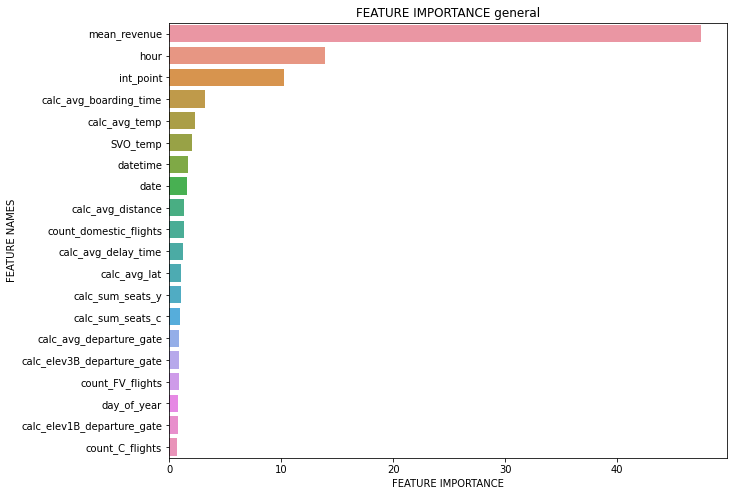

In [283]:
plot_feature_importance(clf.get_feature_importance(),X.columns, "general", save_img=True)

/var/folders/gj/xhzsd7h13fj01p074fh66b0w0000gn/T/ipykernel_55940/1245722287.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,8))


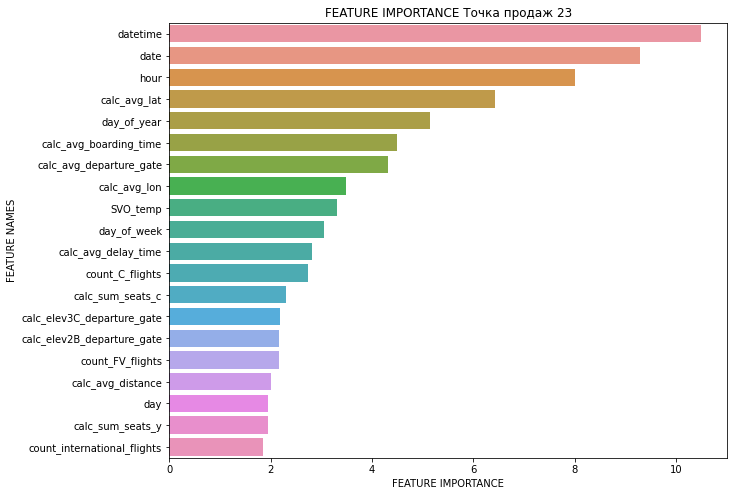

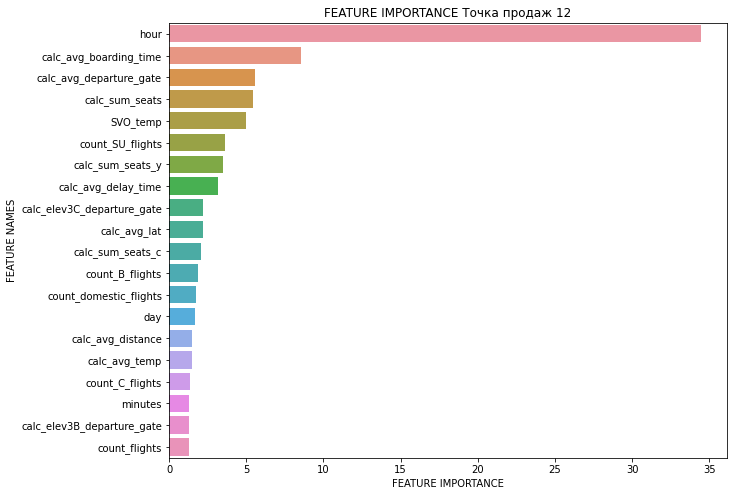

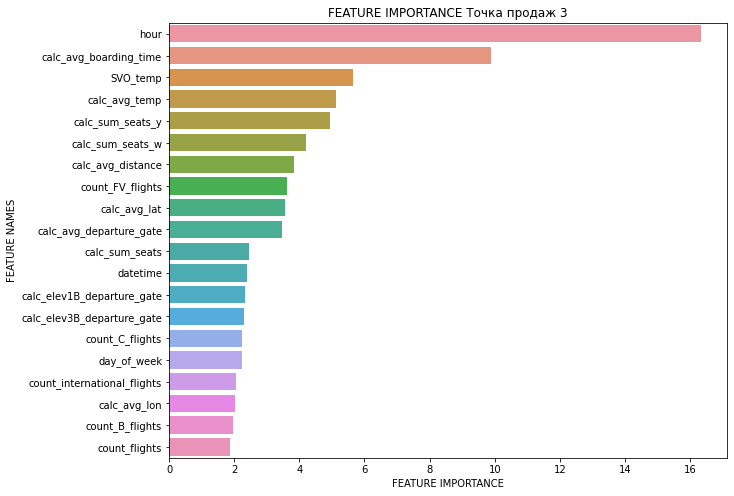

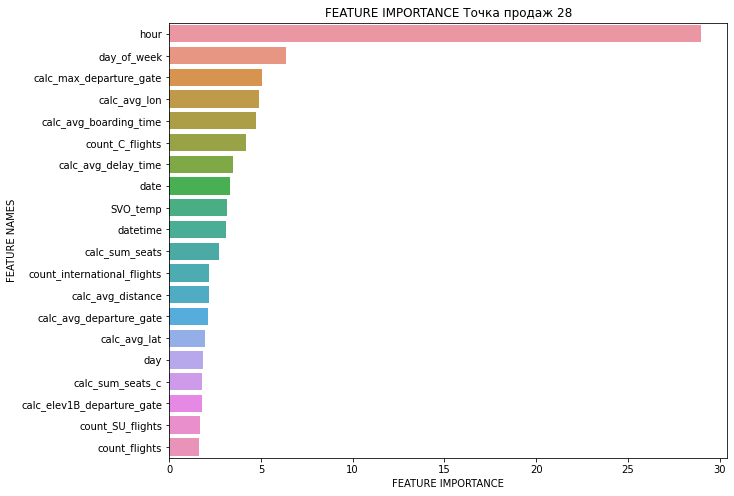

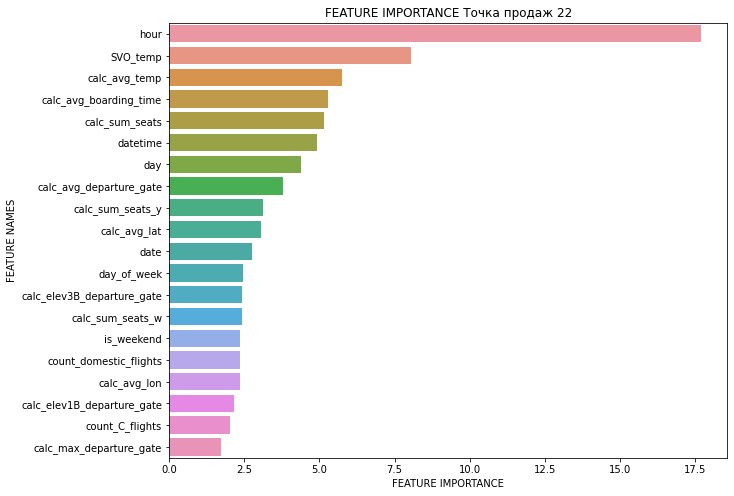

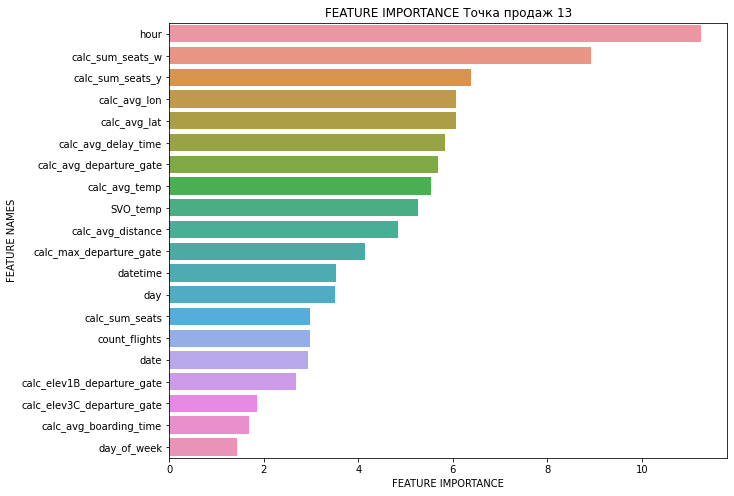

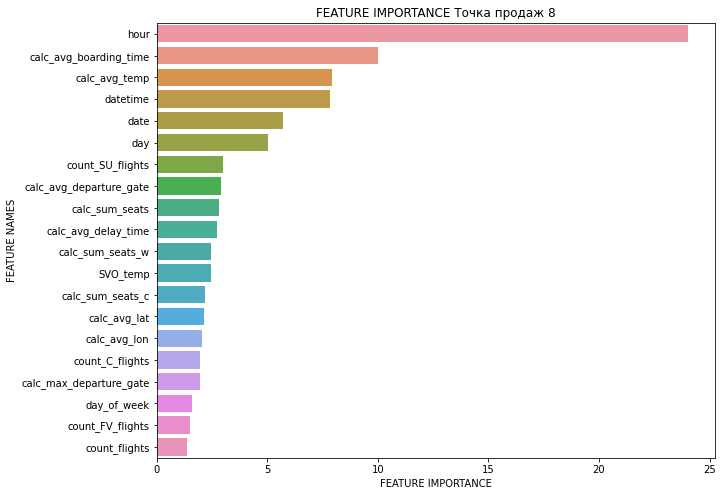

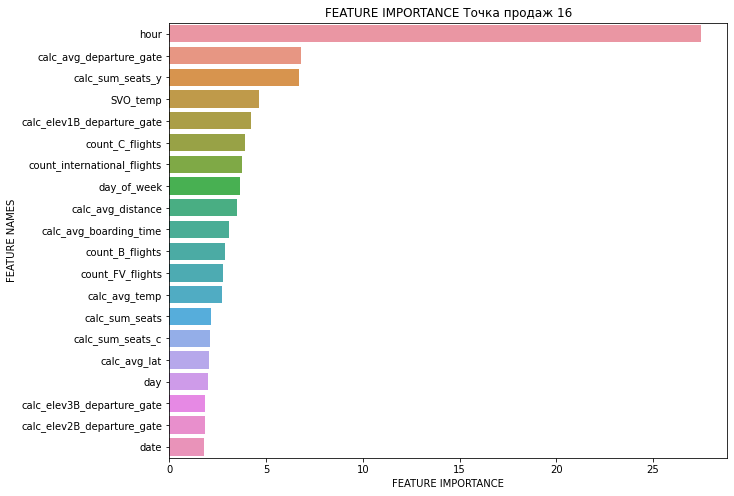

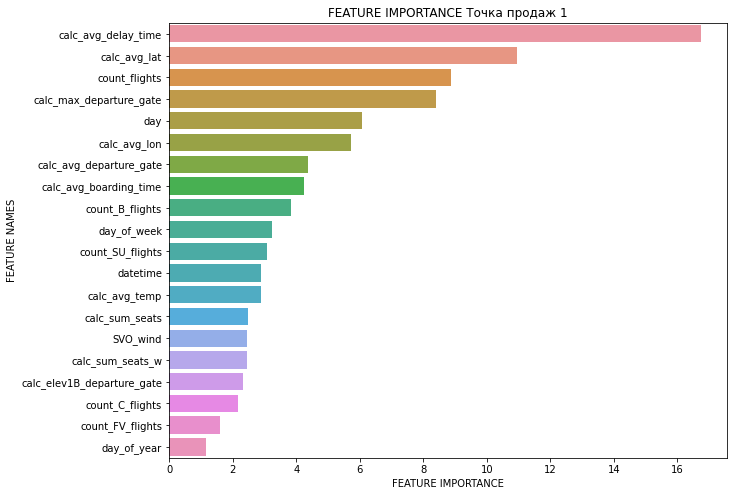

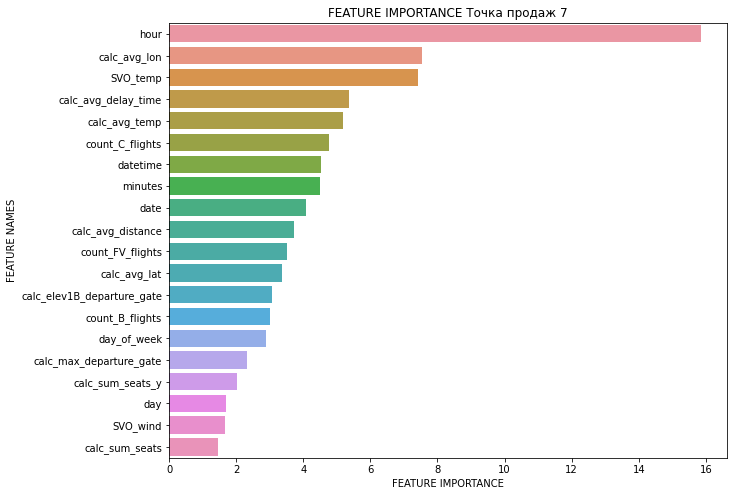

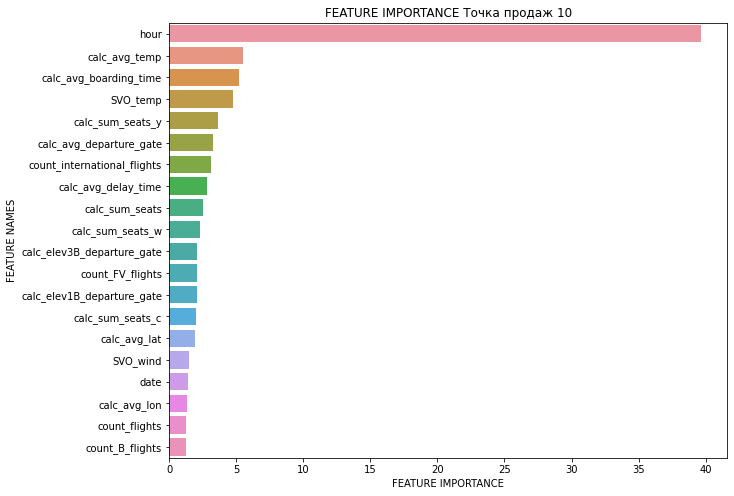

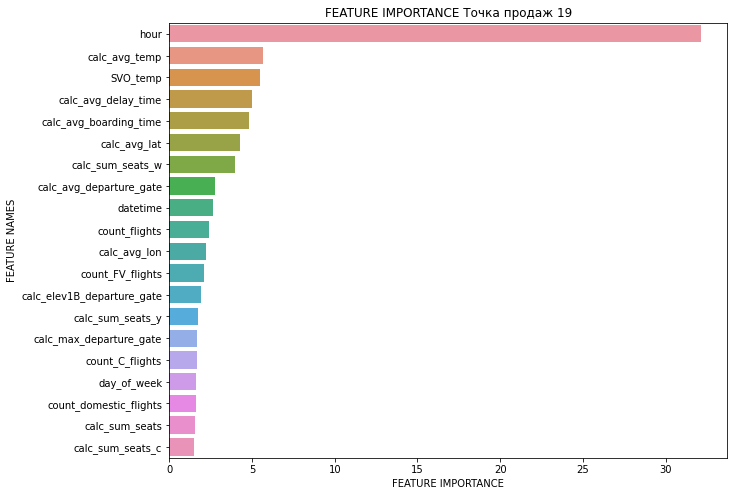

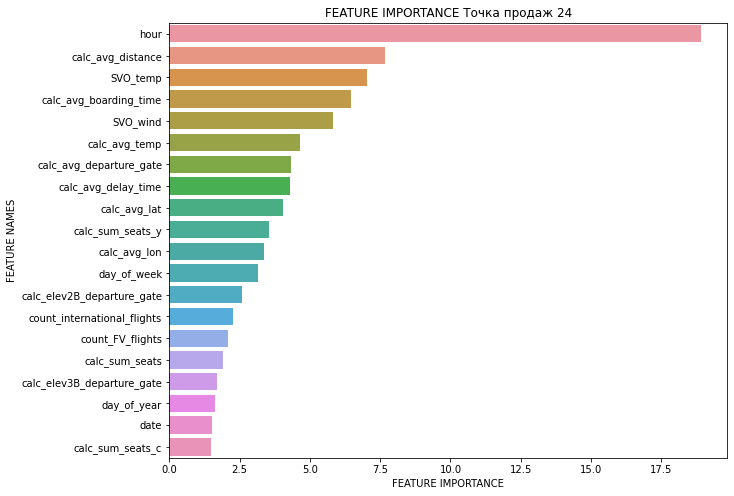

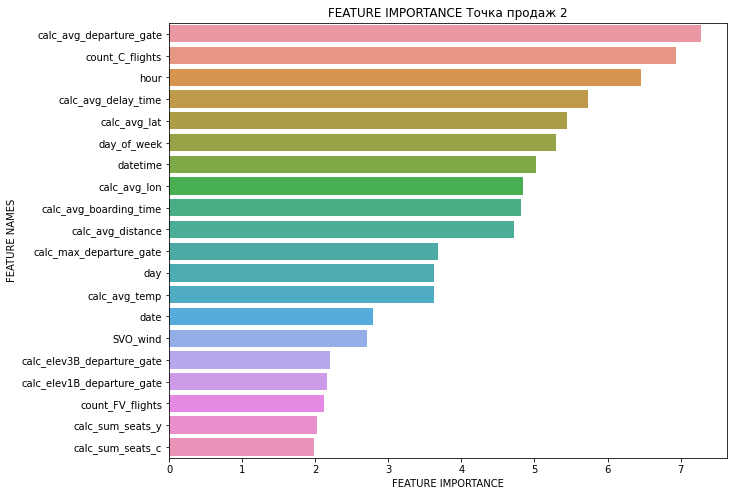

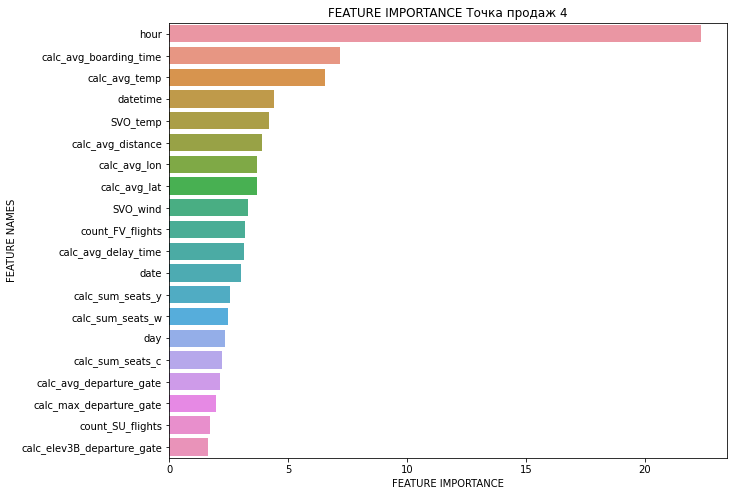

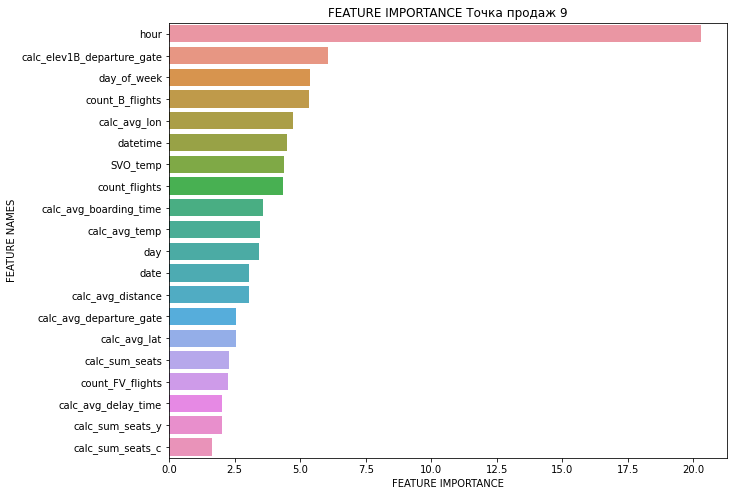

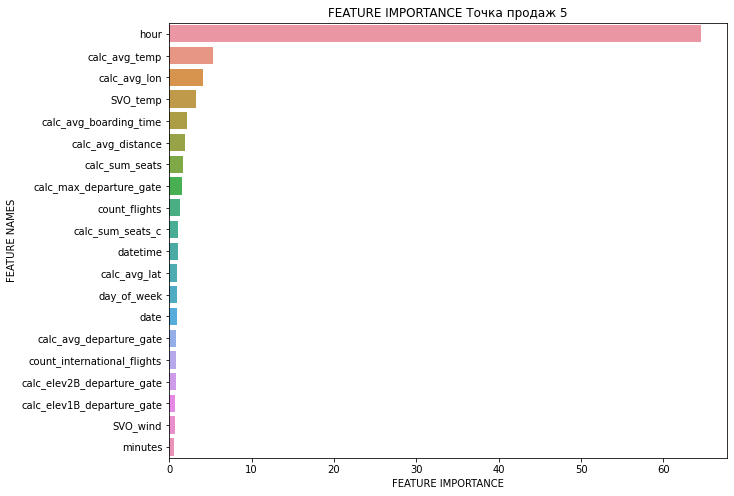

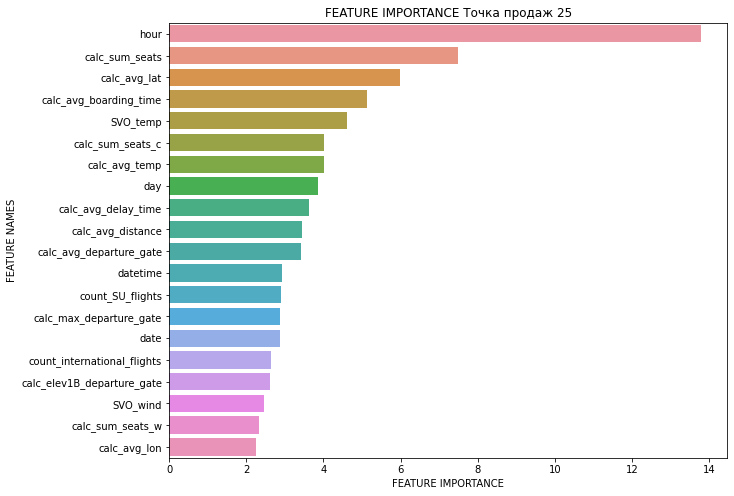

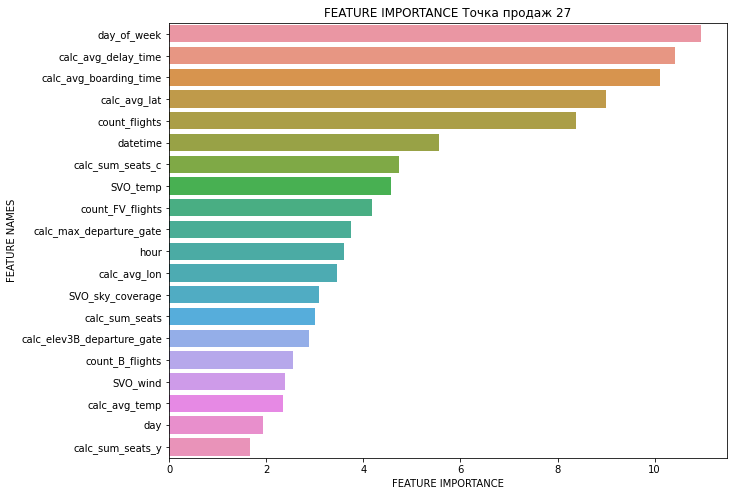

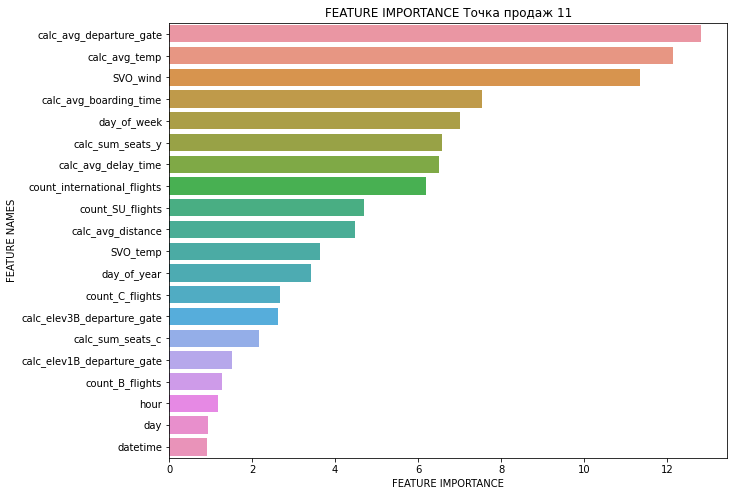

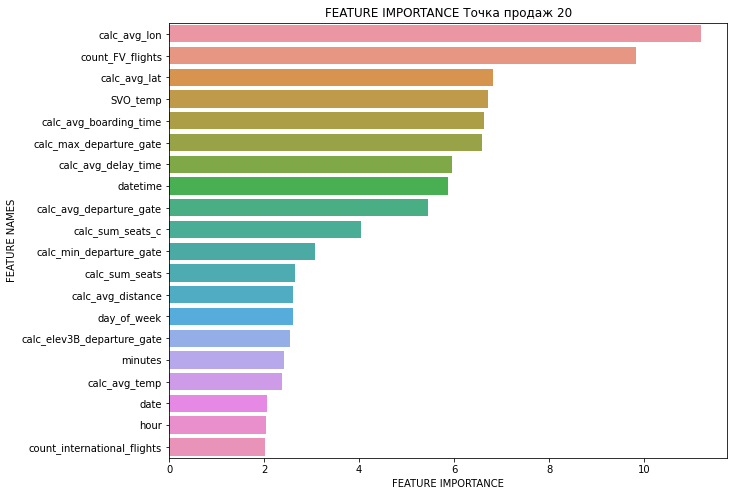

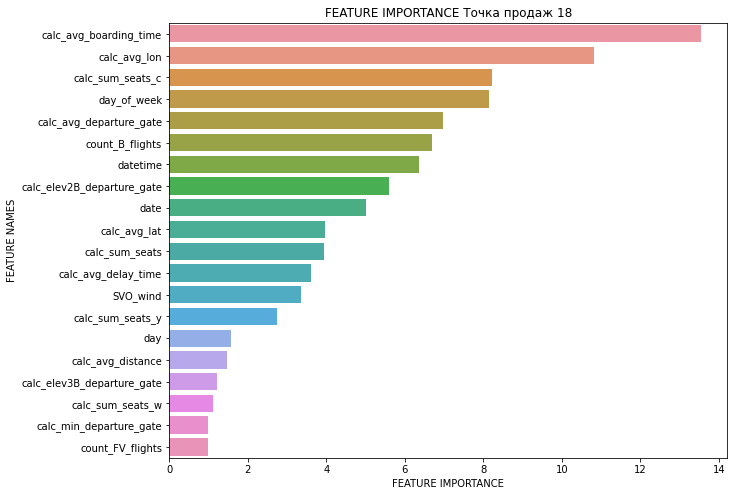

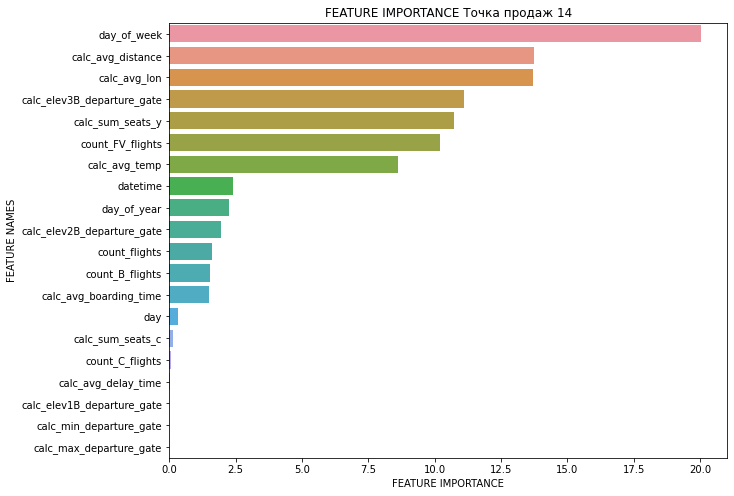

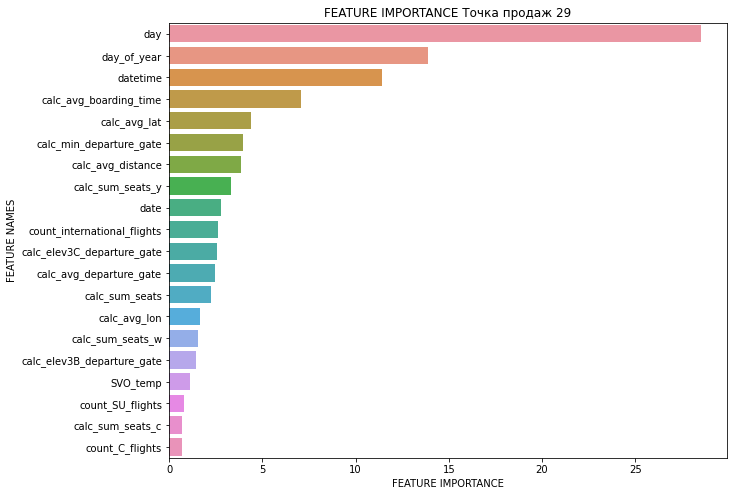

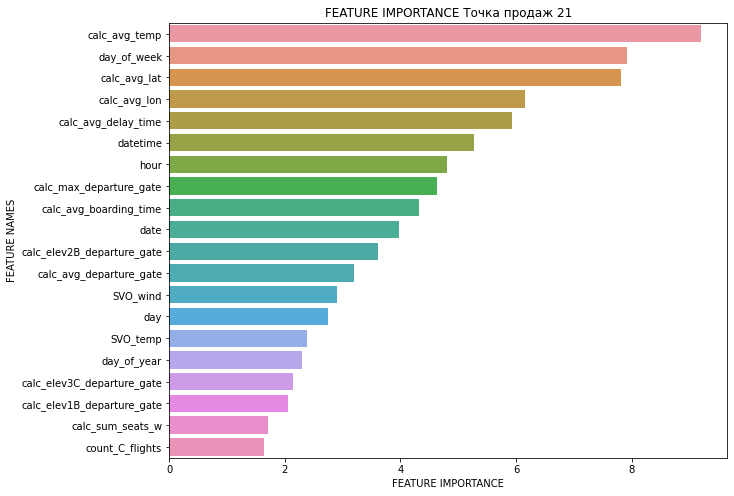

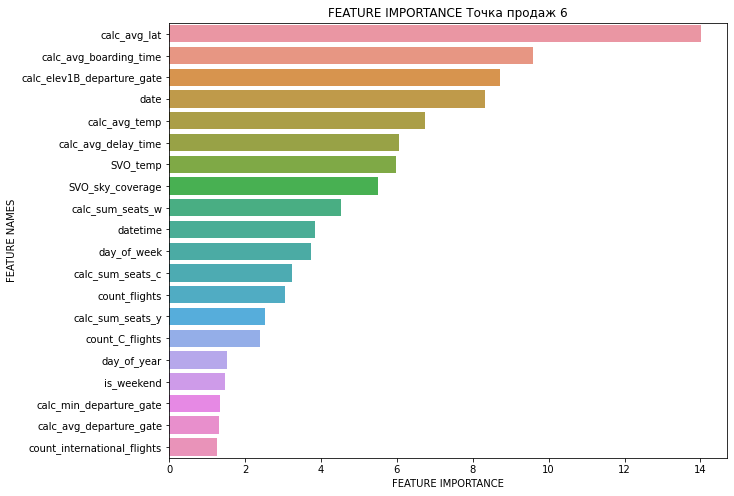

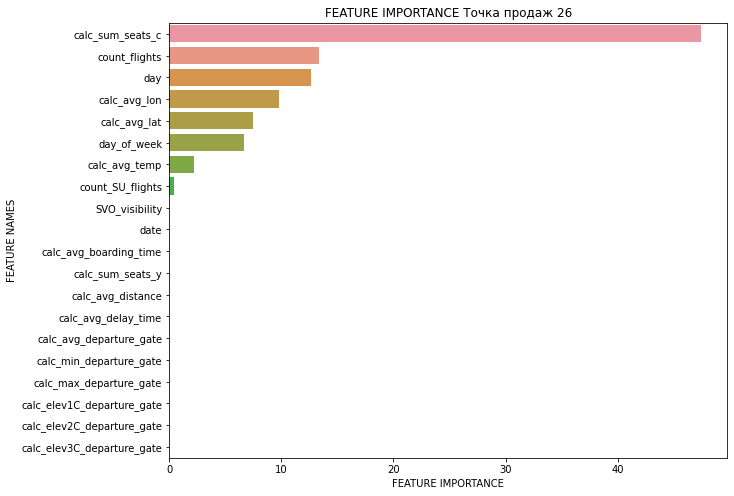

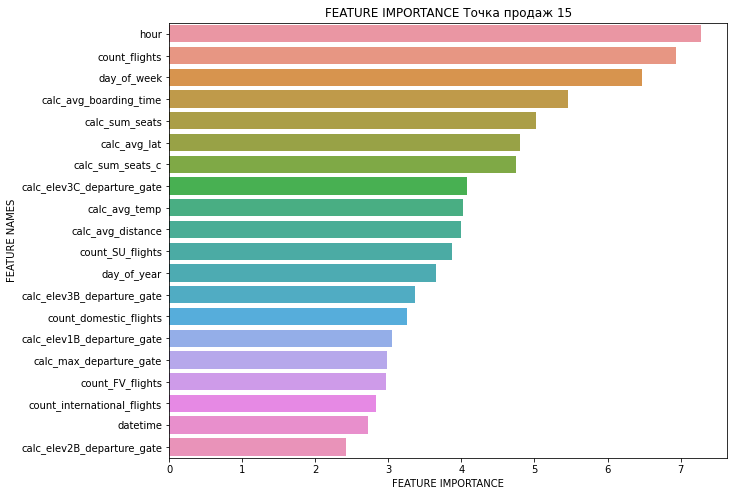

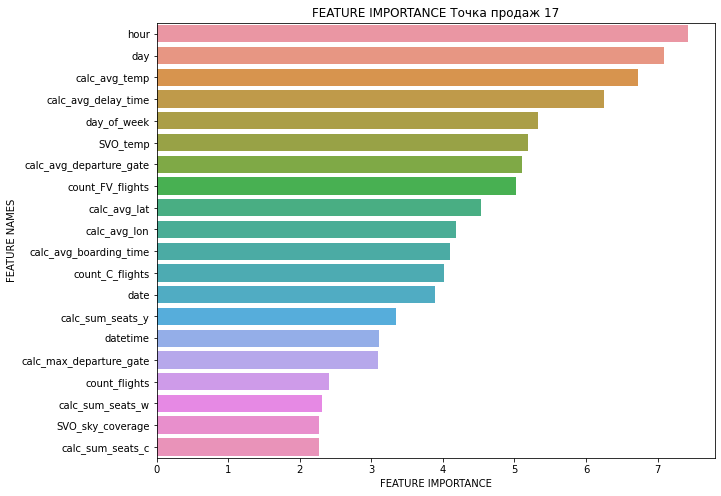

In [284]:
scores = pd.DataFrame(columns=["point", "mae", "rmse", "min", "max"])

for i in df_05.point.unique():
    df2 = df_05[df_05["point"]==i]
    X = df2.drop(columns=['timeThirty', 'timeHour', 'revenue', 'point', 
                      # 'mean_revenue'
                     ])
    y = df2['revenue']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = CatBoostRegressor(random_state=42, eval_metric="RMSE", iterations=100)
    clf.fit(X_train, y_train,
        # cat_features=["point"],
        eval_set=(X_test, y_test),
        plot=False, verbose=False
    )
    y_predicted = clf.predict(X_test)
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    mae = mean_absolute_error(y_test, y_predicted)
    scores.loc[len(scores)] = [i, mae, rmse, df2.revenue.min(), df2.revenue.max()]
    plot_feature_importance(clf.get_feature_importance(), X.columns, i, save_img=True)

In [290]:
scores["accuracy, %"] = (1 - scores["mae"] / (scores["max"] - scores["min"])) * 100
scores["int_point"] = scores["point"].apply(lambda x: x.split(" ")[-1:][0]).astype(int)

In [291]:
scores[["point", "int_point", "mae", "min", "max", "accuracy, %"]].sort_values(by="int_point")

,point,int_point,mae,min,max,"accuracy, %"
8,Точка продаж 1,1,160.023919,18.500,1430.00,88.662847
13,Точка продаж 2,2,1206.249958,1.500,8829.00,86.335316
2,Точка продаж 3,3,1126.799280,98.500,11695.50,90.283700
14,Точка продаж 4,4,898.768769,74.500,7040.00,87.096852
16,Точка продаж 5,5,2108.687595,4.500,28954.10,92.716004
25,Точка продаж 6,6,235.034586,125.000,2025.00,87.629759
9,Точка продаж 7,7,704.073754,225.000,8550.00,91.542658
6,Точка продаж 8,8,1952.626363,120.000,25813.50,92.400310
15,Точка продаж 9,9,2792.369903,22.365,40004.26,93.015914
10,Точка продаж 10,10,1392.268252,73.500,14936.50,90.632657


In [292]:
scores.mae.min(), scores.mae.max(), scores.mae.mean()

(160.02391867817641, 9297.106521310205, 2226.5586371828585)

In [293]:
scores["accuracy, %"].min(), scores["accuracy, %"].max(), scores["accuracy, %"].mean()

(86.33531625456553, 96.69342197753177, 90.90909091379324)

In [294]:
scores[["point", "int_point", "mae", "min", "max", "accuracy, %"]].sort_values(by="int_point").to_csv("train_scores.csv", index=False)

### Fit final model (May 2022)

In [297]:
X = df_05.drop(columns=['timeThirty', 'timeHour', 'revenue', 'point', 
                      # 'mean_revenue',
                     ])
y = df_05['revenue']

In [298]:
clf = CatBoostRegressor(random_state=42, eval_metric="RMSE", iterations=100)
clf.fit(X, y,
        # cat_features=["point"],
        plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.448987
0:	learn: 4834.3345293	total: 4.25ms	remaining: 421ms
1:	learn: 4359.9255279	total: 7.92ms	remaining: 388ms
2:	learn: 4180.3517679	total: 11.4ms	remaining: 368ms
3:	learn: 4005.8126663	total: 14.4ms	remaining: 346ms
4:	learn: 3942.4028861	total: 17.6ms	remaining: 334ms
5:	learn: 3899.8606496	total: 20.4ms	remaining: 320ms
6:	learn: 3853.5853379	total: 22.9ms	remaining: 305ms
7:	learn: 3809.3666651	total: 25.5ms	remaining: 293ms
8:	learn: 3776.3699660	total: 28.6ms	remaining: 289ms
9:	learn: 3753.6273518	total: 31.1ms	remaining: 280ms
10:	learn: 3738.9904596	total: 34.1ms	remaining: 276ms
11:	learn: 3717.1735873	total: 36.5ms	remaining: 268ms
12:	learn: 3686.7066561	total: 39ms	remaining: 261ms
13:	learn: 3671.9356277	total: 41.2ms	remaining: 253ms
14:	learn: 3651.4242662	total: 44.1ms	remaining: 250ms
15:	learn: 3632.0318379	total: 46.8ms	remaining: 246ms
16:	learn: 3620.3145340	total: 49.5ms	remaining: 242ms
17:	learn: 3603.3597752	total: 52ms	remaining: 

In [299]:
clf.save_model("./svo_hack_model/version2")

## Collect june dataset

In [300]:
df_06 = collect_df(revenue_06)

--- Part 1/4 ---


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

--- Part 2/4 ---


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

--- Part 3/4 ---


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

--- Part 4/4 ---


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

### Score

In [409]:
df_06["int_point"] = df_06["point"].apply(lambda x: x.split(" ")[-1:][0])
df_06["int_point"] = df_06["int_point"].astype(int)

X = df_06.drop(columns=['timeThirty', 'timeHour', 'revenue', 'point', 
                      # 'mean_revenue',
                     ])
y = df_06['revenue']

In [410]:
y_predicted = clf.predict(X)
rmse = mean_squared_error(y, y_predicted, squared=False)
mae = mean_absolute_error(y, y_predicted)
rmse, mae

(5318.563659779347, 2864.12349821048)

In [303]:
scores = pd.DataFrame(columns=["point", "mae", "rmse", "min", "max"])

for i in df_06.point.unique():
    df2 = df_06[df_06["point"]==i]
    X = df2.drop(columns=['timeThirty', 'timeHour', 'revenue', 'point', 
                      # 'mean_revenue'
                     ])
    y = df2['revenue']
    
    y_predicted = clf.predict(X)
    rmse = mean_squared_error(y, y_predicted, squared=False)
    mae = mean_absolute_error(y, y_predicted)
    scores.loc[len(scores)] = [i, mae, rmse, df2.revenue.min(), df2.revenue.max()]
    
scores["accuracy, %"] = (1 - scores["mae"] / (scores["max"] - scores["min"])) * 100
scores["int_point"] = scores["point"].apply(lambda x: x.split(" ")[-1:][0]).astype(int)

In [305]:
scores.mae.min(), scores.mae.max(), scores.mae.mean()

(480.677433196011, 10247.21124065997, 2773.1140774360065)

In [306]:
scores["accuracy, %"].min(), scores["accuracy, %"].max(), scores["accuracy, %"].mean()

(69.83832673092783, 96.35240972329801, 88.68735484634371)

In [307]:
scores[["point", "int_point", "mae", "min", "max", "accuracy, %"]].sort_values(by="int_point")

,point,int_point,mae,min,max,"accuracy, %"
18,Точка продаж 1,1,487.838351,55.00,1898.000,73.530203
16,Точка продаж 2,2,1754.935559,89.50,10485.500,83.119127
20,Точка продаж 3,3,1647.642408,94.50,25260.500,93.452903
9,Точка продаж 4,4,1285.721296,32.50,14714.500,91.242874
1,Точка продаж 5,5,3858.697751,10.50,55542.000,93.051335
23,Точка продаж 6,6,480.677433,125.00,2425.000,79.100981
12,Точка продаж 7,7,1000.326797,125.00,11625.000,91.301506
5,Точка продаж 8,8,3226.943026,120.00,37088.000,91.270983
10,Точка продаж 9,9,4022.867382,10.85,46415.305,91.330860
6,Точка продаж 10,10,2027.344807,73.50,22006.500,90.756646


### Make submission file

In [411]:
X = df_06.drop(columns=['timeThirty', 'timeHour', 'revenue', 'point', 
                      # 'mean_revenue',
                     ])
y = df_06['revenue']

y_predicted = clf.predict(X)

In [412]:
my_answers = pd.DataFrame({"predicted": y_predicted})

In [420]:
submission = df_06.merge(my_answers, left_index=True, right_index=True)[["date", "timeThirty", "revenue", "predicted", "point"]]
submission["predicted"] = submission["predicted"].apply(lambda x: 0 if x < 0 else x)
submission

,date,timeThirty,revenue,predicted,point
0,2022-05-31,2022-05-31 23:30:00+00:00,540.0,5837.565098,Точка продаж 15
1,2022-05-31,2022-05-31 23:30:00+00:00,438.5,2555.405835,Точка продаж 5
2,2022-06-01,2022-06-01 00:00:00+00:00,290.0,3070.968176,Точка продаж 14
3,2022-06-01,2022-06-01 00:00:00+00:00,3125.0,2876.254750,Точка продаж 19
4,2022-06-01,2022-06-01 00:00:00+00:00,3845.0,1364.446219,Точка продаж 16
...,...,...,...,...,...
28779,2022-07-01,2022-07-01 00:00:00+00:00,2053.0,5352.417946,Точка продаж 8
28780,2022-07-01,2022-07-01 00:00:00+00:00,54.0,1921.533269,Точка продаж 22
28781,2022-07-01,2022-07-01 00:00:00+00:00,508.0,2834.961344,Точка продаж 12
28782,2022-07-01,2022-07-01 00:00:00+00:00,197.5,1278.327408,Точка продаж 24


In [421]:
mean_absolute_error(submission["revenue"], submission["predicted"])

2842.612338937844

In [422]:
np.absolute(submission["revenue"] - submission["predicted"]).min()

0.0

In [423]:
np.absolute(submission["revenue"] - submission["predicted"]).max()

94383.03553855002

In [424]:
scores[["point", "int_point", "mae", "min", "max", "accuracy, %"]].sort_values(by="int_point").to_csv("test_scores.csv", index=False)

In [429]:
def draw_real_vs_predict(point_title = "Точка продаж 19"):
    figure(figsize=(40, 16),)
    plt.title(f'Фактическая vs предсказанная выручка для {point_title}')
    plt.xlabel('Дата и время')
    plt.ylabel('Выручка')
    plt.plot(
            submission[submission["point"] == point_title]["timeThirty"].to_list(), 
            submission[submission["point"] == point_title]["revenue"].to_list(),
            label='Фактическая выручка'
        )
    plt.plot(
        submission[submission["point"] == point_title]["timeThirty"].to_list(),
        submission[submission["point"] == point_title]["predicted"].to_list(),
        label='Предсказанная выручка'
    )
    plt.grid()
    plt.legend(prop={'size':20})
    plt.savefig(f'./svo_hack_images/Фактическая vs предсказанная выручка для {point_title}.png', bbox_inches='tight')

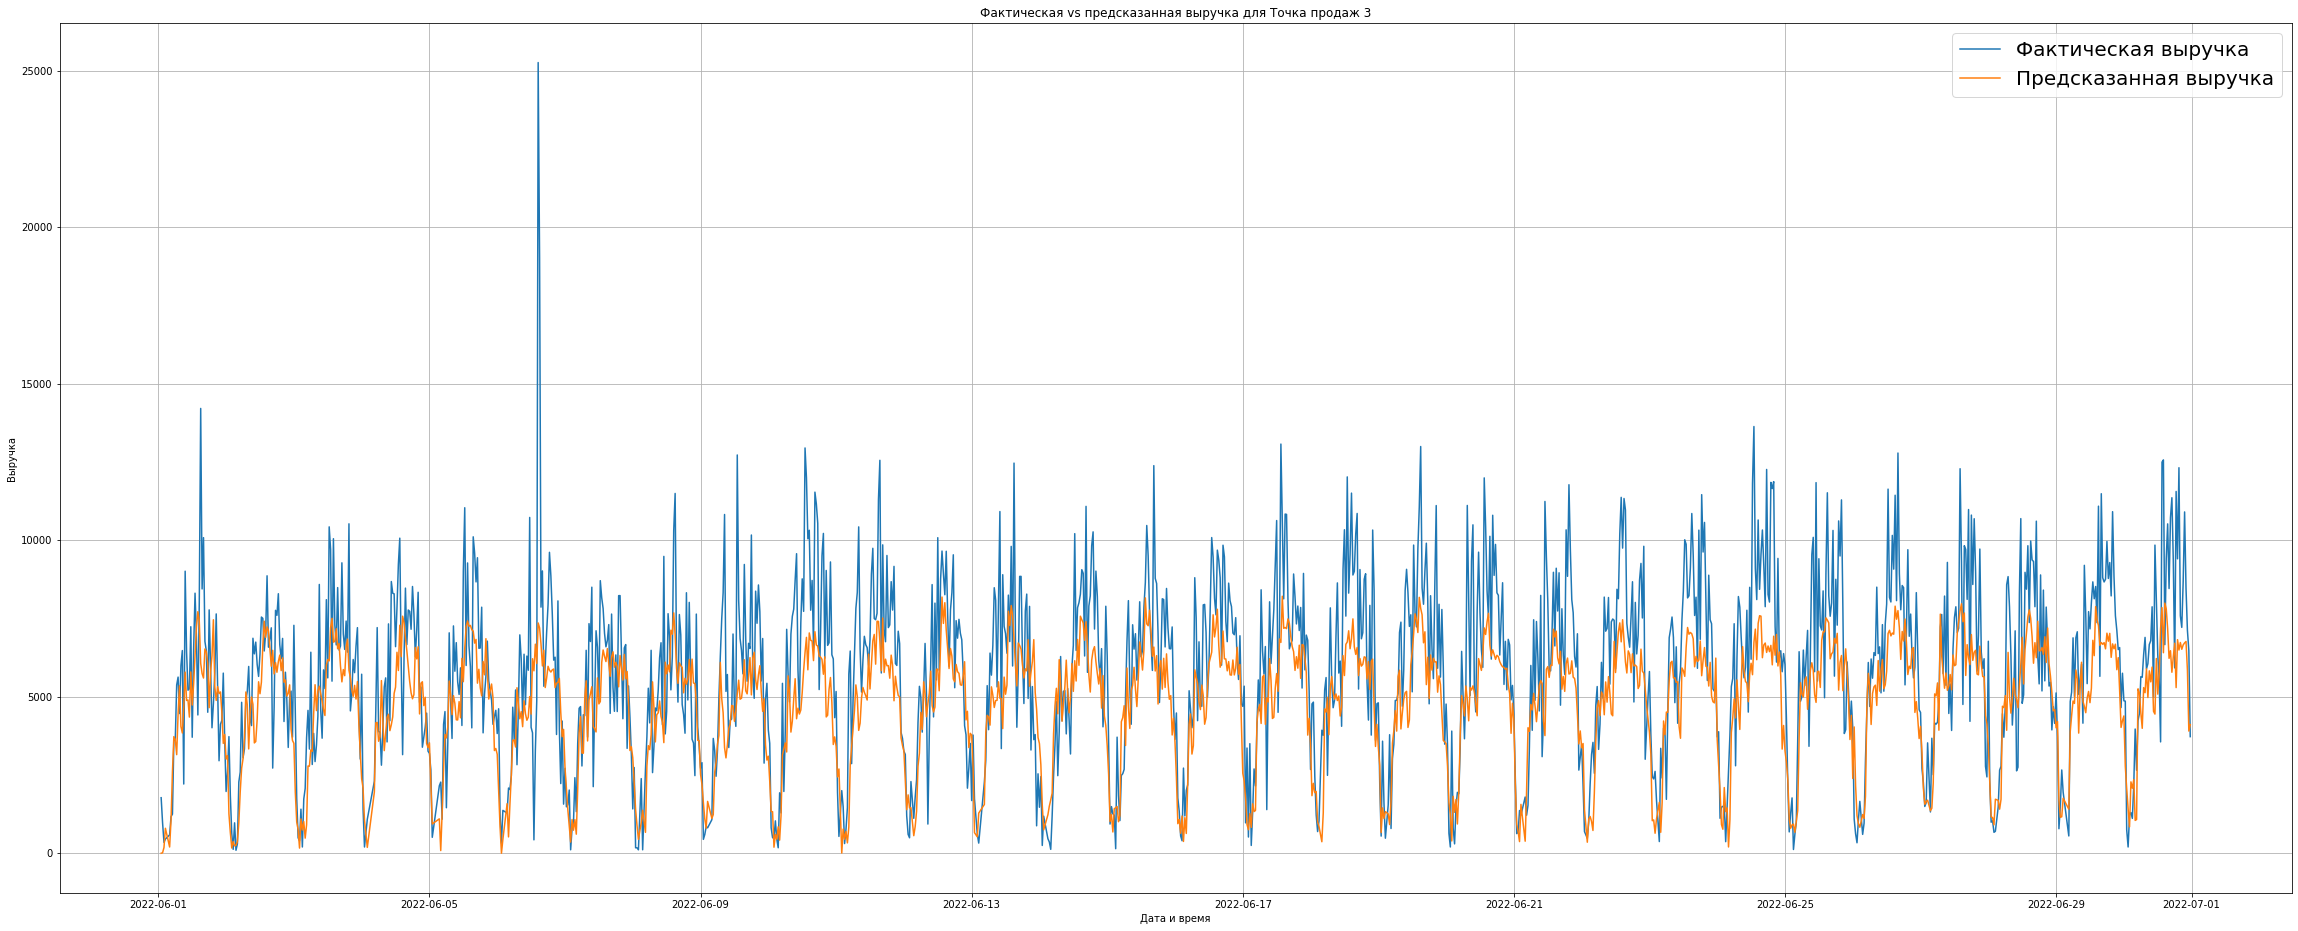

In [430]:
draw_real_vs_predict("Точка продаж 3")

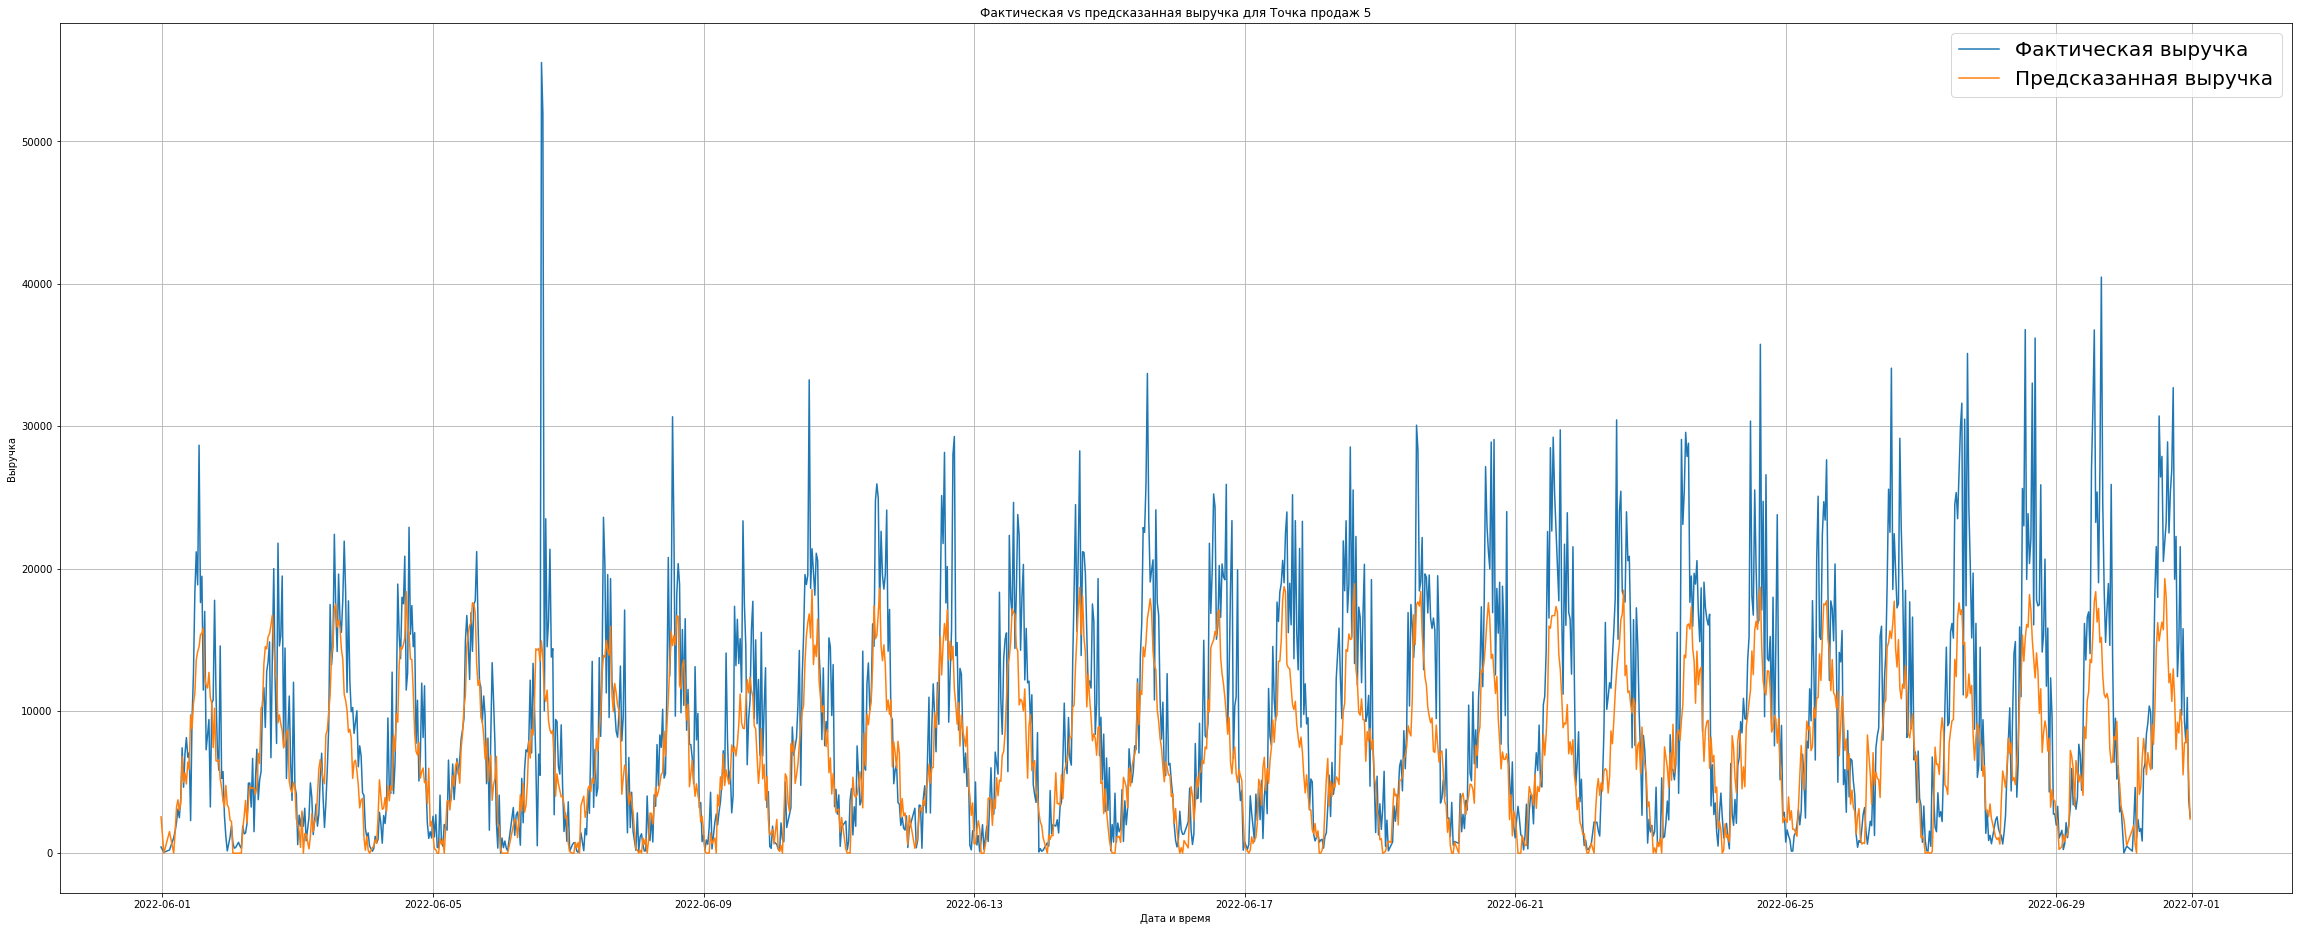

In [431]:
draw_real_vs_predict("Точка продаж 5")

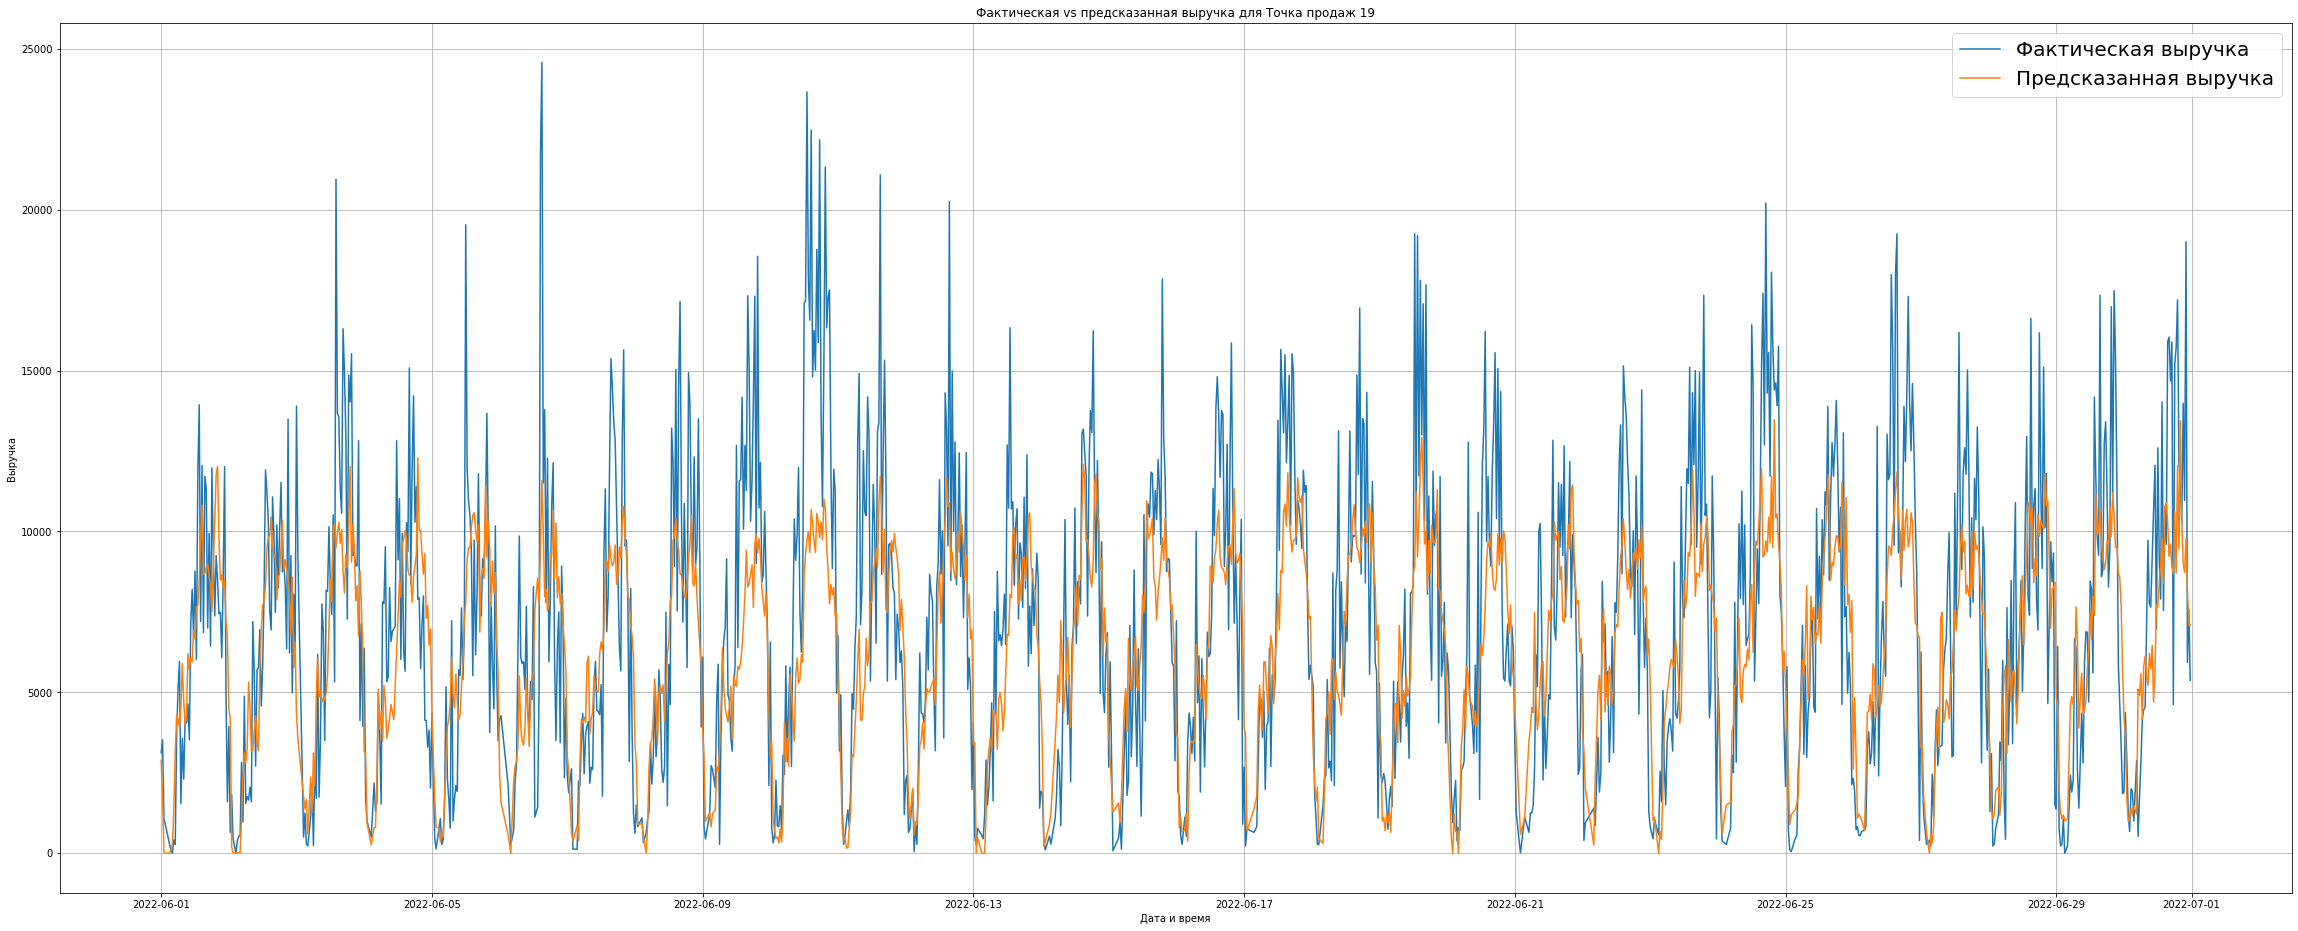

In [432]:
draw_real_vs_predict("Точка продаж 19")

In [407]:
df_05.to_csv("revenue_05.csv", index=False)
df_06.to_csv("revenue_06.csv", index=False)

In [408]:
dep.to_csv("dep_final.csv", index=False)
arr.to_csv("arr_final.csv", index=False)

In [433]:
submission.to_csv("svo_submission.csv", index=False)